Compare the performance between Gerstner's trip model and TripNet performance by calculating the MSE of data used by Gerstner. Plot the predicted data v.s. raw data in stdp, triplet and quadruplet protocol.

In [1]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sb
from modelval import pairptl, network, trainer, dataset, data_aug_knn, perform_eval
from modelval.ArbDataGen import arb_w_gen
from modelval.spk_visu import spk_see, raster
from modelval import gp_regressor
from modelval import data_aug_gp
from sklearn.model_selection import train_test_split
from scipy import stats
from modelval import TripModel, network
from modelval.ArbDataGen import arb_w_gen
from modelval import TripNet, spk_gen
% matplotlib inline

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
trip_para = pd.read_pickle('/src/Plasticity_Ker/data/Gerstner_trip_para_df')
trip_para
# Reorder columns to match parameter of the model
trip_para = trip_para[['A2_+', 'A3_-', 'A2_-', 'A3_+', 'Tau_+', 'Tau_x', 'Tau_-', 'Tau_y']]
trip_para

A2_+     A3_-    A2_-    A3_+ Tau_+ Tau_x Tau_-  \
Visu_AlltoAll    Full    5e-10  0.00023   0.007  0.0062  16.8   101  33.7   
                 Min         0        0  0.0071  0.0065  16.8     1  33.7   
Visu_NearestSpk  Full  8.8e-11   0.0031  0.0066   0.053  16.8   714  33.7   
                 Min         0        0   0.008    0.05  16.8     1  33.7   
Hippo_AlltoAll   Full   0.0061   0.0014  0.0016  0.0067  16.8   946  33.7   
                 Min    0.0053        0  0.0035   0.008  16.8     1  33.7   
Hippo_NearestSpk Full   0.0046  7.5e-09   0.003  0.0091  16.8   575  33.7   
                 Min    0.0046        0   0.003  0.0091  16.8     1  33.7   

                      Tau_y  
Visu_AlltoAll    Full   125  
                 Min    114  
Visu_NearestSpk  Full    40  
                 Min     40  
Hippo_AlltoAll   Full    27  
                 Min     40  
Hippo_NearestSpk Full    47  
                 Min     48

In [3]:
# Visualize kernel
from modelval.kernel import KernelGen
ker_test = KernelGen()

para = trip_para.loc[('Hippo_AlltoAll', 'Min'), :]
a = para[:4].values
tau = para[4:].values
reso_set = 2
tau_pre_post = tau[0]/reso_set  # ms
tau_post_pre = tau[2]/reso_set # ms

len_kernel=101
ker_test = KernelGen(len_kernel=len_kernel)
ker_test.trip_model_ker(para, data_name='Hippocampus')

In [4]:
# Load STDP data with +10 ms and =10 ms time difference
data = pd.read_csv('/src/Plasticity_Ker/data/kernel_training_data_auto.csv')

data4 = data[data['ptl_idx']==4]
dt1 = np.array([5,10,5,15])
dt2 = np.array([-5,-10,-15,-5])

df4_net = pd.DataFrame(data=None, columns=list(data.columns))

for i in range(len(dt1)):
    new_entry = data4[data4['dt1']>0].iloc[0]
    new_entry['dt1'] = dt1[i]
    new_entry['dt2'] = dt2[i]
    df4_net = df4_net.append(new_entry, ignore_index=True)

df4_net

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste,train_len
0,4.0,1.0,0.0,2.0,0.0,60.0,1.0,5.0,-5.0,0.0,20.722837,7.54679,60.0
1,4.0,1.0,0.0,2.0,0.0,60.0,1.0,10.0,-10.0,0.0,20.722837,7.54679,60.0
2,4.0,1.0,0.0,2.0,0.0,60.0,1.0,5.0,-15.0,0.0,20.722837,7.54679,60.0
3,4.0,1.0,0.0,2.0,0.0,60.0,1.0,15.0,-5.0,0.0,20.722837,7.54679,60.0


In [5]:
# Generate spike pairs
ptl_list = [4]
spk_len = int(df4_net['train_len'].max() * 1000 / ker_test.reso_kernel)
if_noise = 0
aug_times = [1]
spk_pairs, _ = arb_w_gen(df=df4_net, ptl_list=ptl_list, if_noise=if_noise, spk_len=spk_len, kernel=ker_test, net_type='triplet', aug_times=aug_times)

In [6]:
# Load TripNet and Model
# Create the network
ground_truth_init = 0
reg_scale=(1, 1)
init_seed=(4,5,6,7)
toy_data_net = network.TripNet(kernel=ker_test, ground_truth_init=ground_truth_init, init_seed=init_seed, reg_scale=reg_scale, n_input=spk_pairs.shape[1])

In [7]:
# Create the trainer
save_dir= '/src/Plasticity_Ker/model/Trip_ptl1_4_real_aug_no_noise'
save_dir= '/src/Plasticity_Ker/model/Pair_ptl1_4_real_aug_gp_no_noise'

toy_net_trainer = trainer.Trainer(toy_data_net.loss, toy_data_net.loss, input_name=toy_data_net.inputs, target_name=toy_data_net.target, save_dir=save_dir, optimizer_config={'learning_rate': toy_data_net.lr})

[array([-0.99108154, -1.03684831,  3.08487582], dtype=float32), array([[ 5.58297682]], dtype=float32)]


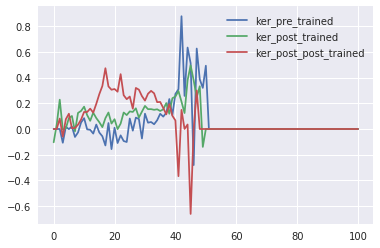

In [8]:
toy_net_trainer.restore_best()
w_pre = toy_net_trainer.evaluate(ops=toy_data_net.kernel_pre)
w_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post)
w_post_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post_post)
fc_w = toy_net_trainer.evaluate(ops=toy_data_net.fc_w)
bias = toy_net_trainer.evaluate(ops=toy_data_net.bias).reshape(-1,1)
plt.plot(-1*w_pre, label='ker_pre_trained')
plt.plot(-1*w_post, label='ker_post_trained')
plt.plot(-1 * w_post_post, label='ker_post_post_trained')
plt.legend()
print([fc_w, bias])

In [9]:
# Generate prediction with triplet network
ker_test.kernel_pre = w_pre
ker_test.kernel_post = w_post
ker_test.kernel_post_post= w_post_post
ker_test.kernel_scale = fc_w
ker_test.bias = bias

_, pred4_net = arb_w_gen(spk_pairs=spk_pairs, spk_len=spk_len, kernel=ker_test, net_type='triplet')
pred4_net = pred4_net/100

In [10]:
# Generate spike pairs for generating tripmodel prediction
ptl_list = [4]
ker_test.reso_kernel=0.5
spk_len = int(df4_net['train_len'].max() * 1000 / ker_test.reso_kernel)
if_noise = 0
aug_times = [1]
spk_pairs, _ = arb_w_gen(df=df4_net, ptl_list=ptl_list, if_noise=if_noise, spk_len=spk_len, kernel=ker_test, net_type='triplet', aug_times=aug_times)

In [11]:
# Obtain the pre-post scatter plot
loci_pre = []
loci_post = []
dt_mean = []
for i in range(spk_pairs.shape[0]):
    loci_pre_tmp = np.where(spk_pairs[i,:,0]==1)[0]
    loci_post_tmp = np.where(spk_pairs[i,:,1]==1)[0]
    if len(loci_pre_tmp) == len(loci_post_tmp) * 2:   # Pre-post-pre
        loci_pre.append(loci_pre_tmp)
        loci_post.append(loci_post_tmp)
        index_pre = np.arange(0,len(loci_pre_tmp),2)
        dt_mean.append(np.mean(loci_post_tmp - loci_pre_tmp[index_pre]))
    elif len(loci_post_tmp) == len(loci_pre_tmp) * 2:   # Post-pre-post
        loci_pre.append(loci_pre_tmp)
        loci_post.append(loci_post_tmp)
        index_post = np.arange(0,len(loci_post_tmp),2)
        dt_mean.append(np.mean(loci_post_tmp[index_post] - loci_pre_tmp))
    else:
        print('Wrong length!!')
        
loci_track_pre = [loci_pre[i] for i in range(len(loci_pre))]
loci_track_post = [loci_post[i] for i in range(len(loci_post))]

In [12]:
def raster(event_times_list, trial_length,  **kwargs):
    """
    Creates a raster plot
    Parameters
    ----------
    event_times_list : iterable
                       a list of event time iterables
    color : string
            color of vlines
    Returns
    -------
    ax : an axis containing the raster plot
    """
    ax = plt.gca()
    for ith, trial in enumerate(event_times_list):
        plt.vlines(trial[trial_length]*2, ith + .5, ith + 1.5, **kwargs)
    plt.ylim(.5, len(event_times_list) + .5)
    return ax

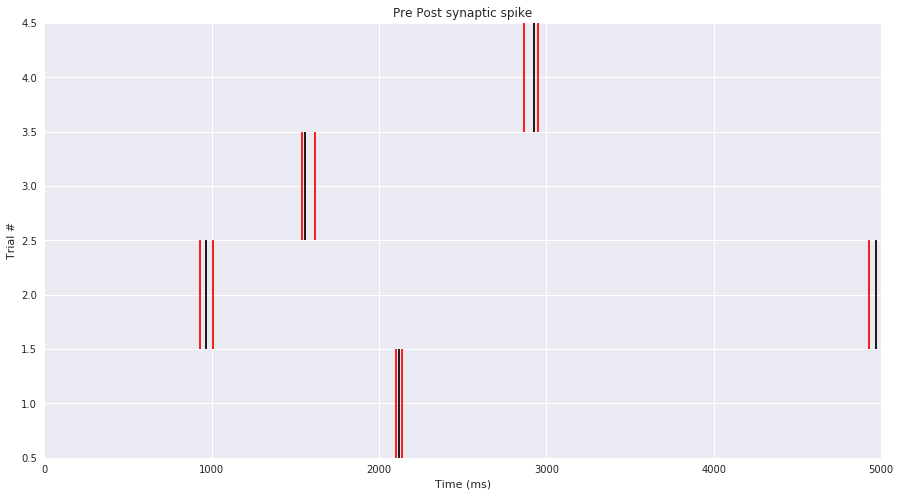

In [13]:
fig = plt.figure(figsize=(15, 8))
trial_length1 = np.arange(0,10)
trial_length2 = np.arange(0,5)
ax = raster(loci_track_pre, trial_length1)
ax = raster(loci_track_post, trial_length2, color='r')
plt.title('Pre Post synaptic spike')
plt.xlabel('Time (ms)')
plt.ylabel('Trial #')
plt.legend()
plt.xlim([0,5000])
fig.show()

In [14]:
para = trip_para.loc[('Hippo_AlltoAll', 'Min'), :]
a = para[:4].values
tau = para[4:].values
reso_set = 0.5

w_AA_full, S_AA_full, pred4_model = TripModel.trip_AlltoAll(a, tau/reso_set, loci_track_pre, loci_track_post, ifSTDP=0, reso = reso_set, tt_len = 60)

([<matplotlib.axis.XTick at 0x7fa751ee2a90>,
 <a list of 4 Text xticklabel objects>)

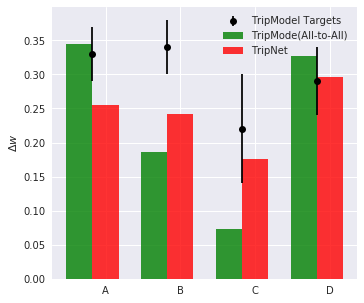

In [15]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
bar_width = 0.35
opacity = 0.8
index = np.arange(4)
plt.errorbar(x=np.arange(4)+bar_width/2,y=np.array([0.33,0.34,0.22,0.29]), yerr=np.array([0.04,0.04,0.08,0.05]),color='k', fmt='o', label='TripModel Targets')
plt.bar(index, list(pred4_model), bar_width,alpha=opacity,label='TripMode(All-to-All)', color='g',align="center")
plt.bar(index+bar_width,list(pred4_net), bar_width, alpha=opacity,color='r',align="center", label='TripNet')
plt.ylabel('$\Delta w$')
plt.legend(loc='upper right')
plt.xticks(index + bar_width, ('A', 'B', 'C', 'D'))

In [16]:
def err(target, pred, sigma):
    err = np.sum(np.square((target-pred)/sigma))
    return err

err_model = err(np.array([0.33,0.34,0.22,0.29]),pred4_model, np.array([0.04,0.04,0.08,0.05]))
err_net = err(np.array([0.33,0.34,0.22,0.29]), pred4_net.reshape(1,4), np.array([0.04,0.04,0.08,0.05]))

print(err_model, err_net)

18.7166772772 9.72543290745
